In [1]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
from sklearn.metrics import silhouette_samples, silhouette_score, davies_bouldin_score

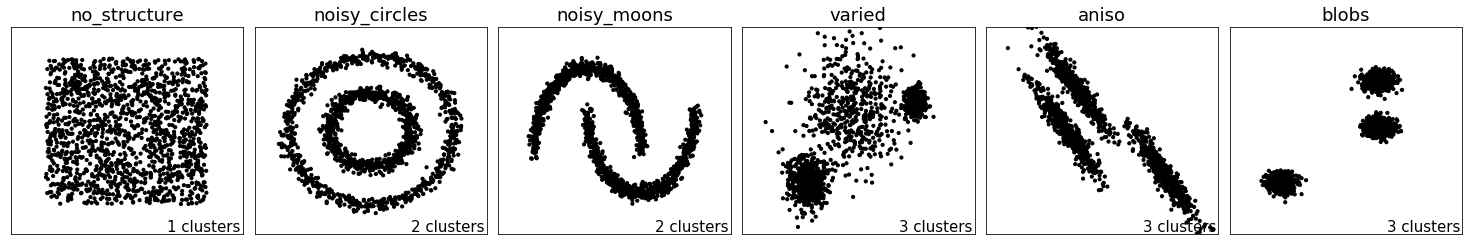

In [2]:
# ===========================================================================================
# Generate datasets.
# Code from Scikit-learning page: Comparing different clustering algorithms on toy datasets
# Link: https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html 
# ===========================================================================================

n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), np.zeros(n_samples, dtype=np.int64)

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

data_sets = {# name, data, number of clusters
             'no_structure': (no_structure, 1),
             'noisy_circles': (noisy_circles, 2), 
             'noisy_moons': (noisy_moons, 2), 
             'varied': (varied, 3), 
             'aniso': (aniso, 3), 
             'blobs': (blobs, 3)}

plt.figure(figsize=(9 * 2 + 3, 3))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05, hspace=.01)

for i_dataset, setname in enumerate(data_sets):

    dataset, nclusters = data_sets[setname]
    
    X, _ = dataset
    y = -1*np.ones(n_samples, dtype=np.int64)

    # normalize dataset for easier parameter selection
    X_scaled = StandardScaler().fit_transform(X)

    plt.subplot(1, len(data_sets), i_dataset+1)
    plt.title(setname, size=18)

    colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                         '#f781bf', '#a65628', '#984ea3',
                                         '#999999', '#e41a1c', '#dede00']),
                                  int(max(y) + 1))))
    # add black color for outliers (if any)
    colors = np.append(colors, ["#000000"])
    plt.scatter(X_scaled[:, 0], X_scaled[:, 1], s=10, color=colors[y])

    plt.xlim(-2.5, 2.5)
    plt.ylim(-2.5, 2.5)
    plt.xticks(())
    plt.yticks(())
    plt.text(.99, .01, ('%.0f clusters' % (nclusters)).lstrip('0'),
             transform=plt.gca().transAxes, size=15,
             horizontalalignment='right')
        
plt.show()

In [41]:
# INPUT: dataset name
setname = 'varied' # no_structure, noisy_circles, noisy_moons, varied, aniso, blobs

parameters_base = { # parameter, value 
                    'quantile': .3,
                    'eps': .3,
                    'damping': .9,
                    'preference': -200,
                    'n_neighbors': 10,
                    'n_clusters': 3,
                    'min_samples': 20,
                    'xi': 0.05,
                    'min_cluster_size': 0.1}

parameters_dataset = { 
    # set name, (parameter, value)
    'no_structure': {},
    'noisy_circles': {'damping': .77, 'preference': -240, 'quantile': .2, 'n_clusters': 2, 'min_samples': 20, 'xi': 0.25},
    'noisy_moons': {'damping': .75, 'preference': -220, 'n_clusters': 2},
    'varied': {'eps': .18, 'n_neighbors': 2, 'min_samples': 5, 'xi': 0.035, 'min_cluster_size': .2},
    'aniso': {'eps': .15, 'n_neighbors': 2, 'min_samples': 20, 'xi': 0.1, 'min_cluster_size': .2},
    'blobs': {},
}

n_clusters = range(2,6) #range(2,11)

score_algorithms = [silhouette_score, davies_bouldin_score]
score_names = ['silhouette (max)', 'davies b. (min)']
score_criteria = (max, min)

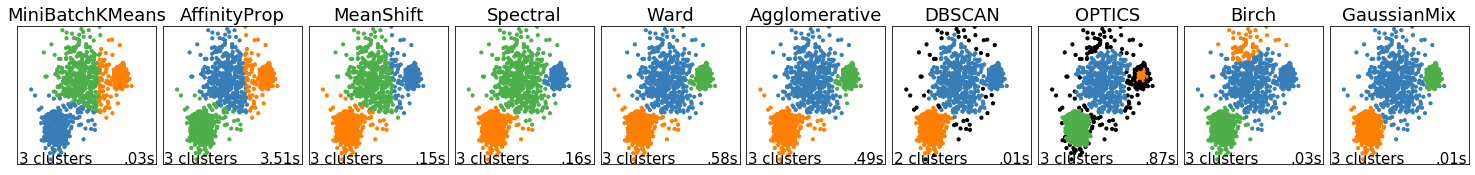

In [4]:
# ===========================================================================================
# Execute clustering algorithms for a specific parameters set
# Algorithms and code from Scikit-learning page: 2.3. Clustering
# Link: https://scikit-learn.org/stable/modules/clustering.html
# ===========================================================================================

# load dataset
dataset, nclusters = data_sets[setname]
X, _ = dataset

# normalize dataset for easier parameter selection
X_scaled = StandardScaler().fit_transform(X)

# update parameters with dataset-specific values
params = parameters_base.copy()
params.update(parameters_dataset[setname])

# estimate bandwidth for mean shift
bandwidth = cluster.estimate_bandwidth(X_scaled, quantile=params['quantile'])

# connectivity matrix for structured Ward
connectivity = kneighbors_graph(X_scaled, n_neighbors=params['n_neighbors'], include_self=False)
# make connectivity symmetric
connectivity = 0.5 * (connectivity + connectivity.T)

# ============
# Create cluster objects
# ============
ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
ward = cluster.AgglomerativeClustering(n_clusters=params['n_clusters'], linkage='ward', connectivity=connectivity)
spectral = cluster.SpectralClustering(n_clusters=params['n_clusters'], eigen_solver='arpack', affinity="nearest_neighbors")
dbscan = cluster.DBSCAN(eps=params['eps'])
optics = cluster.OPTICS(min_samples=params['min_samples'], xi=params['xi'], min_cluster_size=params['min_cluster_size'])
affinity_propagation = cluster.AffinityPropagation(damping=params['damping'], preference=params['preference'])
average_linkage = cluster.AgglomerativeClustering(linkage="average", affinity="cityblock", n_clusters=params['n_clusters'], connectivity=connectivity)
birch = cluster.Birch(n_clusters=params['n_clusters'])
gmm = mixture.GaussianMixture( n_components=params['n_clusters'], covariance_type='full')

clustering_algorithms = {
    # name, algorithm object
    'MiniBatchKMeans': two_means,
    'AffinityProp': affinity_propagation,
    'MeanShift': ms,
    'Spectral': spectral,
    'Ward': ward,
    'Agglomerative': average_linkage,
    'DBSCAN': dbscan,
    'OPTICS': optics,
    'Birch': birch,
    'GaussianMix': gmm
}


plt.figure(figsize=(21, 2))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05, hspace=.01)

for i_algorithm, name in enumerate(clustering_algorithms):
    algorithm = clustering_algorithms[name]
    
    t0 = time.time()

    # catch warnings related to kneighbors_graph
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore",
            message="the number of connected components of the " +
            "connectivity matrix is [0-9]{1,2}" +
            " > 1. Completing it to avoid stopping the tree early.",
            category=UserWarning)
        warnings.filterwarnings(
            "ignore",
            message="Graph is not fully connected, spectral embedding" +
            " may not work as expected.",
            category=UserWarning)
        algorithm.fit(X_scaled)

    t1 = time.time()
    if hasattr(algorithm, 'labels_'):
        y_pred = algorithm.labels_.astype(np.int)
    else:
        y_pred = algorithm.predict(X_scaled)

    plt.subplot(1, len(clustering_algorithms), i_algorithm+1)
    plt.title(name, size=18)

    colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                         '#f781bf', '#a65628', '#984ea3',
                                         '#999999', '#e41a1c', '#dede00']),
                                  int(max(y_pred) + 1))))
    # add black color for outliers (if any)
    colors = np.append(colors, ["#000000"])
    plt.scatter(X_scaled[:, 0], X_scaled[:, 1], s=10, color=colors[y_pred])

    plt.xlim(-2.5, 2.5)
    plt.ylim(-2.5, 2.5)
    plt.xticks(())
    plt.yticks(())
    plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
             transform=plt.gca().transAxes, size=15,
             horizontalalignment='right')
    
    plt.text(.01, .01, ('%.0f clusters' % max(y_pred+1)).lstrip('0'),
             transform=plt.gca().transAxes, size=15,
             horizontalalignment='left')

plt.show()

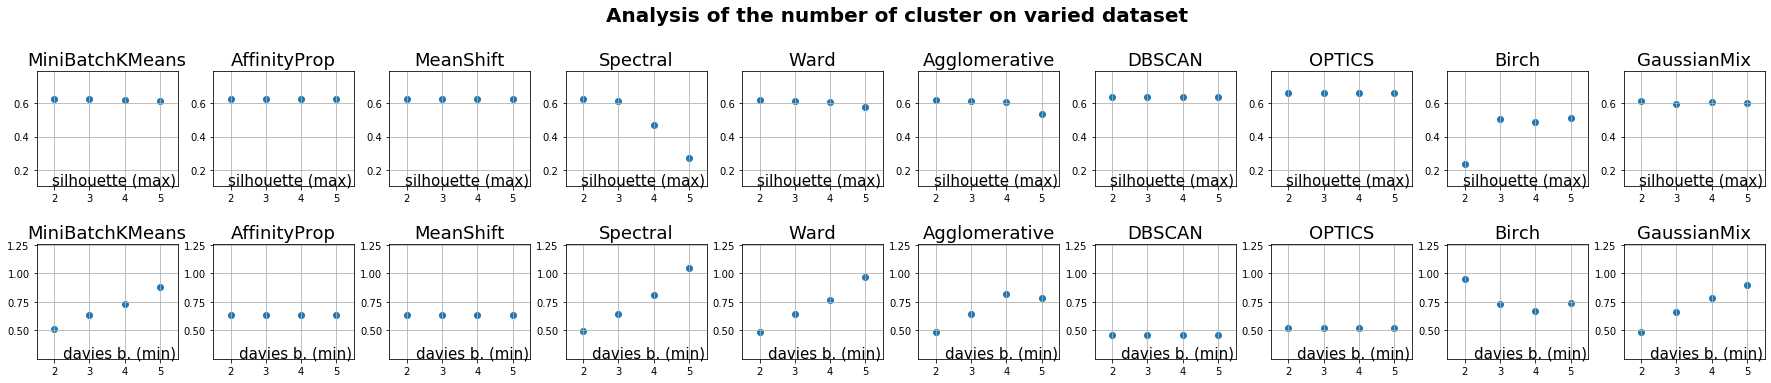

In [42]:
# ===========================================================================================
# Plot scores as function of the number of clusters
# To interpret the graphs, see the Medium article: Clustering metrics better than the elbow-method
# Link: https://towardsdatascience.com/clustering-metrics-better-than-the-elbow-method-6926e1f723a6
# ===========================================================================================

# load dataset
dataset, nclusters = data_sets[setname]
X, _ = dataset

# normalize dataset for easier parameter selection
X_scaled = StandardScaler().fit_transform(X)

# update parameters with dataset-specific values
params = parameters_base.copy()
params.update(parameters_dataset[setname])

# estimate bandwidth for mean shift
bandwidth = cluster.estimate_bandwidth(X_scaled, quantile=params['quantile'])

# connectivity matrix for structured Ward
connectivity = kneighbors_graph(X_scaled, n_neighbors=params['n_neighbors'], include_self=False)
# make connectivity symmetric
connectivity = 0.5 * (connectivity + connectivity.T)

scores = []

for score_algorithm in score_algorithms:
    
    scores_clustering = {
        # clustering algorithm name, list of scores
        'MiniBatchKMeans': [],
        'AffinityProp': [],
        'MeanShift': [],
        'Spectral': [],
        'Ward': [],
        'Agglomerative': [],
        'DBSCAN': [],
        'OPTICS': [],
        'Birch': [],
        'GaussianMix': []
    }
    
    for j_ncluster, ncluster in enumerate(n_clusters):

        # print("Calculating for {} of {} values ofr n_cluster".format(j_ncluster+1, len(n_clusters)))

        params.update({'n_clusters': ncluster})

        # ============
        # Create cluster objects
        # ============
        ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
        two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
        ward = cluster.AgglomerativeClustering(n_clusters=params['n_clusters'], linkage='ward', connectivity=connectivity)
        spectral = cluster.SpectralClustering(n_clusters=params['n_clusters'], eigen_solver='arpack', affinity="nearest_neighbors")
        dbscan = cluster.DBSCAN(eps=params['eps'])
        optics = cluster.OPTICS(min_samples=params['min_samples'], xi=params['xi'], min_cluster_size=params['min_cluster_size'])
        affinity_propagation = cluster.AffinityPropagation(damping=params['damping'], preference=params['preference'])
        average_linkage = cluster.AgglomerativeClustering(linkage="average", affinity="cityblock", n_clusters=params['n_clusters'], connectivity=connectivity)
        birch = cluster.Birch(n_clusters=params['n_clusters'])
        gmm = mixture.GaussianMixture( n_components=params['n_clusters'], covariance_type='full')

        clustering_algorithms = {
            # name, algorithm object
            'MiniBatchKMeans': two_means,
            'AffinityProp': affinity_propagation,
            'MeanShift': ms,
            'Spectral': spectral,
            'Ward': ward,
            'Agglomerative': average_linkage,
            'DBSCAN': dbscan,
            'OPTICS': optics,
            'Birch': birch,
            'GaussianMix': gmm
        }

        for i_algorithm, name in enumerate(clustering_algorithms):
            algorithm = clustering_algorithms[name]

            t0 = time.time()

            # catch warnings related to kneighbors_graph
            with warnings.catch_warnings():
                warnings.filterwarnings(
                    "ignore",
                    message="the number of connected components of the " +
                    "connectivity matrix is [0-9]{1,2}" +
                    " > 1. Completing it to avoid stopping the tree early.",
                    category=UserWarning)
                warnings.filterwarnings(
                    "ignore",
                    message="Graph is not fully connected, spectral embedding" +
                    " may not work as expected.",
                    category=UserWarning)
                algorithm.fit(X_scaled)

            t1 = time.time()
            if hasattr(algorithm, 'labels_'):
                y_pred = algorithm.labels_.astype(np.int)
            else:
                y_pred = algorithm.predict(X_scaled)

            try:
                # Filtering out outliers for DBSCAN and OPTICS
                index_filter = [i for i in range(len(X_scaled)) if y_pred[i] != -1]
                X_filtered = X_scaled[index_filter]
                y_filtered = y_pred[index_filter]
                
                score = score_algorithm(X_filtered,y_filtered)
            except:
                score = np.NaN

            scores_clustering[name].append(score)
            
    scores.append(scores_clustering)
    

plt.figure(figsize=(25, 5))
plt.suptitle('''Analysis of the number of cluster on {} dataset '''.format(setname), fontsize=20, fontweight='bold')
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.8, wspace=.25, hspace=.5)

plot_num = 1
for j_score in range(len(score_algorithms)):
    
    score_clustering = scores[j_score]
    
    ylim = [+np.inf, -np.inf]
    for i_algorithm, clustering_name in enumerate(clustering_algorithms):
        ylim[0] = min(ylim[0], min(score_clustering[clustering_name]))
        ylim[1] = max(ylim[1], max(score_clustering[clustering_name]))
    ylim = [ylim[0]-0.2*max(abs(ylim[0]) ,abs(ylim[1])), ylim[1]+0.2*max(abs(ylim[0]) ,abs(ylim[1]))]
    
    for i_algorithm, clustering_name in enumerate(clustering_algorithms):

        plt.subplot(2, len(clustering_algorithms), plot_num)
        plt.title(clustering_name, size=18)

        plt.scatter(n_clusters, score_clustering[clustering_name])

        plt.xlim(n_clusters[0]-0.5, n_clusters[-1]+0.5)
        plt.ylim(ylim)
        plt.grid()
        #if(i_algorithm != 0): plt.yticks(())
        plt.text(.99, .01, ('%s' % (score_names[j_score])).lstrip('0'),
             transform=plt.gca().transAxes, size=15,
             horizontalalignment='right')        
            
        plot_num += 1

plt.show()

In [43]:
best_Ns = np.zeros([len(score_algorithms), len(clustering_algorithms)]).astype(np.int)
best_scores = np.zeros([len(score_algorithms), len(clustering_algorithms)])

for j_score in range(len(score_algorithms)):
    
    score_clusterings = scores[j_score]
    
    for i_algorithm, clustering_name in enumerate(clustering_algorithms):

        sc = score_clusterings[clustering_name]
        
        score_best = score_criteria[j_score](sc)
        
        index_best = sc.index(score_criteria[j_score](sc)) 
        
        ncluster_best = n_clusters[index_best]
        
        best_Ns[j_score][i_algorithm] = ncluster_best
        best_scores[j_score][i_algorithm] = score_best
          
    indexes_best_alg = np.where(best_scores[j_score][:] == score_criteria[j_score](best_scores[j_score][:]))[0]
    ind = 0     
    best_algorithm = []
    for i_algorithm, clustering_name in enumerate(clustering_algorithms):
        if(i_algorithm == indexes_best_alg[ind]):
            best_algorithm.append(clustering_name)
            ind += 1
            if(ind >= len(indexes_best_alg)): break
        
    print('''Best for {}:'''.format(score_names[j_score]))
    print('''\t Number of clusters per algorithm - {}'''.format(best_Ns[j_score][:]))
    print('''\t Clustering algorithm - {}'''.format(best_algorithm))
    
unique, counts = np.unique(best_Ns, return_counts=True)
best_numberofclusters = unique[np.argmax(counts, axis=None)].astype(np.int)

print('''Best number of clusters by vote: {}'''.format(best_numberofclusters))



Best for silhouette (max):
	 Number of clusters per algorithm - [3 2 2 2 2 2 2 2 5 2]
	 Clustering algorithm - ['OPTICS']
Best for davies b. (min):
	 Number of clusters per algorithm - [2 2 2 2 2 2 2 2 4 2]
	 Clustering algorithm - ['DBSCAN']
Best number of clusters by vote: 2


For n_clusters = 2 The average silhouette_score is : 0.5319819282130047
Excluding the 54 outliers, the average silhouette_score is : 0.6369037571371239


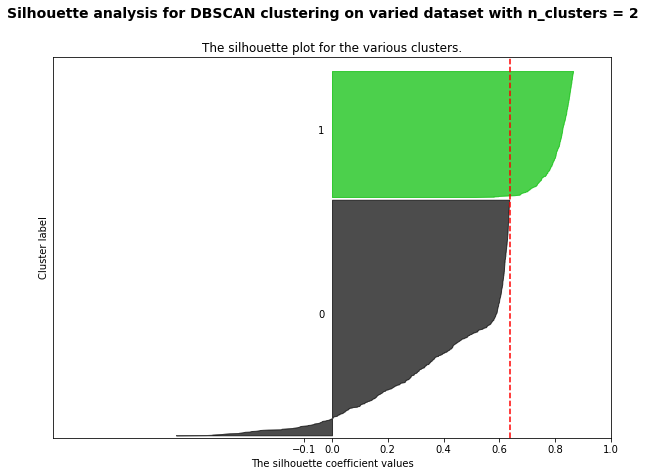

In [45]:
# ===========================================================================================
# Plot silhouette analysis for nameset, using the best algorithm and the best number of clusters
# Code from Scikit learn: Selecting the number of clusters with silhouette analysis on KMeans clustering
# Link: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
# ===========================================================================================

n_clusters = best_numberofclusters
clustering_algorithm = best_algorithm[0]

params.update({'n_clusters': n_clusters})

ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
ward = cluster.AgglomerativeClustering(n_clusters=params['n_clusters'], linkage='ward', connectivity=connectivity)
spectral = cluster.SpectralClustering(n_clusters=params['n_clusters'], eigen_solver='arpack', affinity="nearest_neighbors")
dbscan = cluster.DBSCAN(eps=params['eps'])
optics = cluster.OPTICS(min_samples=params['min_samples'], xi=params['xi'], min_cluster_size=params['min_cluster_size'])
affinity_propagation = cluster.AffinityPropagation(damping=params['damping'], preference=params['preference'])
average_linkage = cluster.AgglomerativeClustering(linkage="average", affinity="cityblock", n_clusters=params['n_clusters'], connectivity=connectivity)
birch = cluster.Birch(n_clusters=params['n_clusters'])
gmm = mixture.GaussianMixture( n_components=params['n_clusters'], covariance_type='full')

clustering_algorithms = {
    # name, algorithm object
    'MiniBatchKMeans': two_means,
    'AffinityProp': affinity_propagation,
    'MeanShift': ms,
    'Spectral': spectral,
    'Ward': ward,
    'Agglomerative': average_linkage,
    'DBSCAN': dbscan,
    'OPTICS': optics,
    'Birch': birch,
    'GaussianMix': gmm
}

algorithm = clustering_algorithms[clustering_algorithm]

X = X_scaled

# catch warnings related to kneighbors_graph
with warnings.catch_warnings():
    warnings.filterwarnings(
        "ignore",
        message="the number of connected components of the " +
        "connectivity matrix is [0-9]{1,2}" +
        " > 1. Completing it to avoid stopping the tree early.",
        category=UserWarning)
    warnings.filterwarnings(
        "ignore",
        message="Graph is not fully connected, spectral embedding" +
        " may not work as expected.",
        category=UserWarning)
    algorithm.fit(X_scaled)

if hasattr(algorithm, 'labels_'):
    cluster_labels = algorithm.labels_.astype(np.int)
else:
    cluster_labels = algorithm.predict(X)

fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(10, 7)

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 
ax1.set_xlim([-1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(X) + (n_clusters) * 10])

# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters
silhouette_avg = silhouette_score(X, cluster_labels)
print("For n_clusters =", n_clusters,
      "The average silhouette_score is :", silhouette_avg)

index_filter = [i for i in range(len(X)) if cluster_labels[i] != -1]
X_filtered = X[index_filter]
cluster_labels_filtered = cluster_labels[index_filter]
silhouette_avg = silhouette_score(X_filtered, cluster_labels_filtered)
print('''Excluding the {} outliers, the average silhouette_score is : {}'''.format((len(X)-len(X_filtered)), silhouette_avg))

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X, cluster_labels)

y_lower = 10
for i in range(0,n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
        sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.suptitle('''Silhouette analysis for {} clustering on {} dataset with n_clusters = {}'''.format(clustering_algorithm, setname, n_clusters),
             fontsize=14, fontweight='bold')

plt.show()